In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
pd.set_option('display.max_columns', None)

In [113]:
df_raw = pd.read_csv('myanimelist_recommender_ready_enriched.csv')


In [114]:
df_raw['score'] = df_raw['score'].apply(lambda x: str(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
df_raw['rank'] = df_raw['rank'].apply(lambda x: str(x).rstrip('0').rstrip('.') if isinstance(x, float) else x)
df_raw['members'] = df_raw['members'].apply(lambda x: f"{int(x):,}" if isinstance(x, int) else x)
mal_ids = [35677, 41457, 52991, 33352] 
df_filtered = df_raw[df_raw['mal_id'].isin(mal_ids)]
print(df_filtered[['mal_id', 'title_english', 'title_japanese', 'type', 'status', 'score', 'rank', 'members']].head().to_latex(index=False).replace("_", "\\_"))

\begin{tabular}{rlllllll}
\toprule
mal\_id & title\_english & title\_japanese & type & status & score & rank & members \\
\midrule
33352 & Violet Evergarden & ヴァイオレット・エヴァーガーデン & TV & Finished Airing & 8.68 & 67 & 1,904,842 \\
35677 & Liz and the Blue Bird & リズと青い鳥 & Movie & Finished Airing & 8.22 & 375 & 154,915 \\
41457 & 86 Eighty-Six & 86―エイティシックス― & TV & Finished Airing & 8.33 & 255 & 890,163 \\
52991 & Frieren: Beyond Journey's End & 葬送のフリーレン & TV & Finished Airing & 9.3 & 1 & 1,140,504 \\
\bottomrule
\end{tabular}



In [115]:
df_raw = pd.read_csv('myanimelist_recommender_ready_enriched.csv')

In [116]:
df_raw.shape

(28707, 28)

In [117]:
df_raw.columns

Index(['mal_id', 'title', 'title_english', 'title_japanese', 'type',
       'episodes', 'status', 'score', 'rank', 'popularity', 'members',
       'favorites', 'synopsis', 'genres', 'themes', 'demographics', 'studios',
       'year', 'url', 'aired_date', 'review_tags_count', 'Creative',
       'MixedFeelings', 'Recommended', 'Funny', 'NotRecommended',
       'Informative', 'Well-written'],
      dtype='object')

In [118]:
df_raw.demographics.unique()

array([nan, 'Shounen', 'Josei', 'Seinen', 'Shoujo', 'Kids',
       'Kids, Shounen', 'Kids, Shoujo', 'Seinen, Shounen'], dtype=object)

In [119]:
df_processed = df_raw.copy()
df_processed = df_processed[df_processed['type'].isin(['TV', 'Movie'])]
df_processed.shape

(13239, 28)

In [120]:
missing_values = df_processed.isnull().sum()
missing_values[missing_values > 0]


title_english        6303
title_japanese         29
episodes              390
score                5369
rank                  437
synopsis             3420
genres               1980
themes               6084
demographics         6823
studios              4971
year                  587
aired_date            587
review_tags_count    7186
dtype: int64

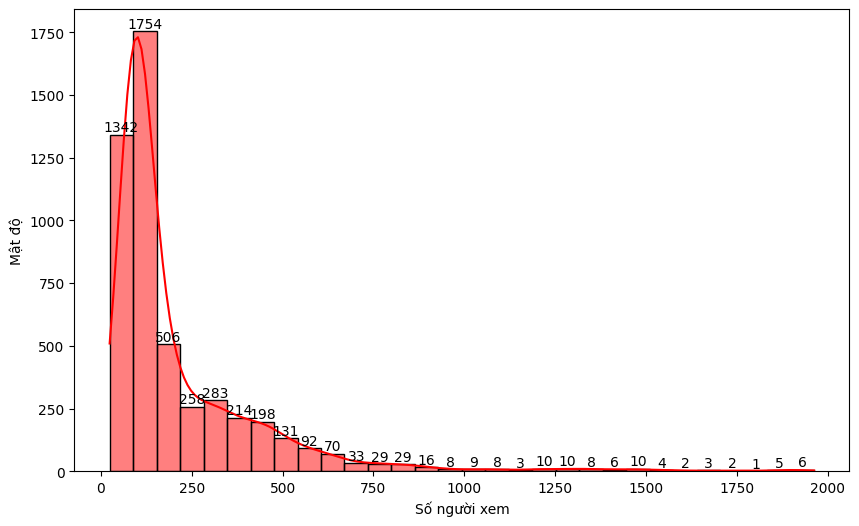

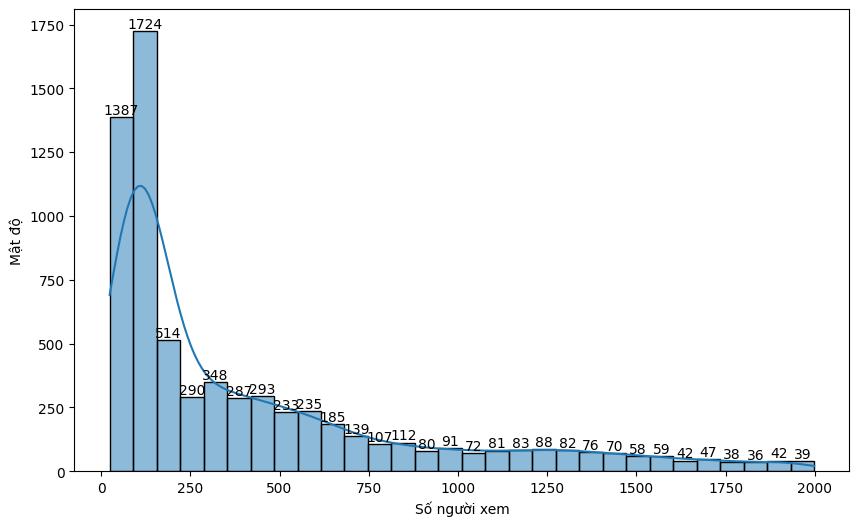

In [121]:
plt.figure(figsize=(10, 6))
df_processed_temp = df_processed[(df_processed['score'].isna()) & (df_processed['members'] < 2000 )].copy()

sns.histplot(
    data=df_processed_temp,
    x='members',
    kde=True,
    color='red',
    stat='count',
    legend=False,
    bins=30
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Số người xem')
plt.ylabel('Mật độ')
plt.show()

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_processed[df_processed['members'] < 2000],
    x='members',
    kde=True,
    stat='count',
    legend=False,
    bins=30
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Số người xem')
plt.ylabel('Mật độ')
plt.show()

In [122]:
df_processed = df_processed[df_processed['score'].notna()]
df_processed.shape

(7870, 28)

In [123]:
missing_values = df_processed.isnull().sum()
missing_values[missing_values > 0]

title_english        2517
title_japanese         22
episodes               34
rank                   21
synopsis              119
genres                377
themes               2578
demographics         5043
studios              1052
year                    4
aired_date              4
review_tags_count    1895
dtype: int64

In [124]:
def one_hot_multilabel(df, col, sep=', ', prefix=None, keep_original=False):
    prefix = prefix or f"{col}_"
    
    df[col] = (
        df[col]
          .fillna('')   
          .apply(lambda s: s.split(sep)
                 if isinstance(s, str) else s) 
    )

    dummies = (
        df[col].str.join('|') 
          .str.get_dummies()   
          .add_prefix(prefix)    
    )

    if keep_original:
        return df.join(dummies)     
    else:
        return pd.concat([df.drop(columns=[col]),   
                           dummies],
                          axis=1)

for col in ['genres', 'themes', 'demographics']:
    df_processed = one_hot_multilabel(df_processed, col, keep_original=True)

In [130]:
df_processed.head(2)


,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [131]:
df_processed.shape

(7870, 106)

In [125]:
categories = ['title', 'title_english', 'title_japanese', 'type', 'status', 'url', 'review_tags_count']
numeric = ['mal_id', 'episodes', 'score', 'rank', 'popularity', 'members', 'year', 'aired_date', 'Creative', 'MixedFeelings', 'Recommended', 'Funny', 'NotRecommended', 'Informative', 'Well-written']

In [126]:
categories = ['type', 'status']
numeric = ['episodes', 'score', 'rank', 'popularity', 'favorite', 'members', 'year', 'aired_date', 'MixedFeelings', 'Recommended', 'NotRecommended']

In [132]:
df = df_processed.copy()

summary_stats = {
    " ": [
        "Mean",
        "Min",
        "Q1",
        "Median",
        "Q3",
        "Max",
        "Mode",
        "Var",
        "SD",
        "CV",
        "IQR"
    ]
}

quantitative_cols = ['score', 'favorites', 'members',  'Recommended', 'MixedFeelings', 'NotRecommended']

def create_summary_df(df, quantitative_cols):
    for col in quantitative_cols:
        data = df[col]
        mean_val = data.mean()
        std_val = data.std()
        mode_val = data.mode().iloc[0] if not data.mode().empty else np.nan
        variance_val = data.var()
        cv_val = std_val / mean_val if mean_val != 0 else np.nan

        summary_stats[col] = [
            mean_val,
            data.min(),
            data.quantile(0.25),
            data.median(),
            data.quantile(0.75),
            data.max(),
            mode_val,
            variance_val,
            std_val,
            cv_val,
            data.quantile(0.75) - data.quantile(0.25)
        ]

    formatted_summary_df = pd.DataFrame(summary_stats).copy()

    for col in formatted_summary_df.columns[1:]:  # Skip "Thông số thống kê"
        formatted_summary_df[col] = formatted_summary_df[col].apply(lambda x: f'{x:,.4f}' if isinstance(x, (int, float)) else x)

    return formatted_summary_df

formatted_summary_df = create_summary_df(df, quantitative_cols)
formatted_summary_df = formatted_summary_df.applymap(lambda x: x.rstrip('0').rstrip('.') if isinstance(x, str) else x)
formatted_summary_df

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11540\2534549043.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_summary_df = formatted_summary_df.applymap(lambda x: x.rstrip('0').rstrip('.') if isinstance(x, str) else x)


,,score,favorites,members,Recommended,MixedFeelings,NotRecommended
0,Mean,6.669,"1,485.5222","120,803.3152",5.0469,1.5848,1.3471
1,Min,2,0,206,0,0,0
2,Q1,6.07,3,"2,162.5",0,0,0
3,Median,6.7,32,"15,593.5",2,1,0
4,Q3,7.33,346,"100,486",9,3,2
5,Max,9.3,"238,872","4,173,914",20,13,17
6,Mode,6.42,0,423,0,0,0
7,Var,0.8738,"71,446,951.132","88,430,158,687.0622",34.0366,4.2754,5.4627
8,SD,0.9348,"8,452.6298","297,372.0879",5.8341,2.0677,2.3372
9,CV,0.1402,5.69,2.4616,1.156,1.3047,1.735


In [134]:
print(formatted_summary_df.to_latex(index=False).replace("_", "\\_"))

\begin{tabular}{lllllll}
\toprule
  & score & favorites & members & Recommended & MixedFeelings & NotRecommended \\
\midrule
Mean & 6.669 & 1,485.5222 & 120,803.3152 & 5.0469 & 1.5848 & 1.3471 \\
Min & 2 & 0 & 206 & 0 & 0 & 0 \\
Q1 & 6.07 & 3 & 2,162.5 & 0 & 0 & 0 \\
Median & 6.7 & 32 & 15,593.5 & 2 & 1 & 0 \\
Q3 & 7.33 & 346 & 100,486 & 9 & 3 & 2 \\
Max & 9.3 & 238,872 & 4,173,914 & 20 & 13 & 17 \\
Mode & 6.42 & 0 & 423 & 0 & 0 & 0 \\
Var & 0.8738 & 71,446,951.132 & 88,430,158,687.0622 & 34.0366 & 4.2754 & 5.4627 \\
SD & 0.9348 & 8,452.6298 & 297,372.0879 & 5.8341 & 2.0677 & 2.3372 \\
CV & 0.1402 & 5.69 & 2.4616 & 1.156 & 1.3047 & 1.735 \\
IQR & 1.26 & 343 & 98,323.5 & 9 & 3 & 2 \\
\bottomrule
\end{tabular}



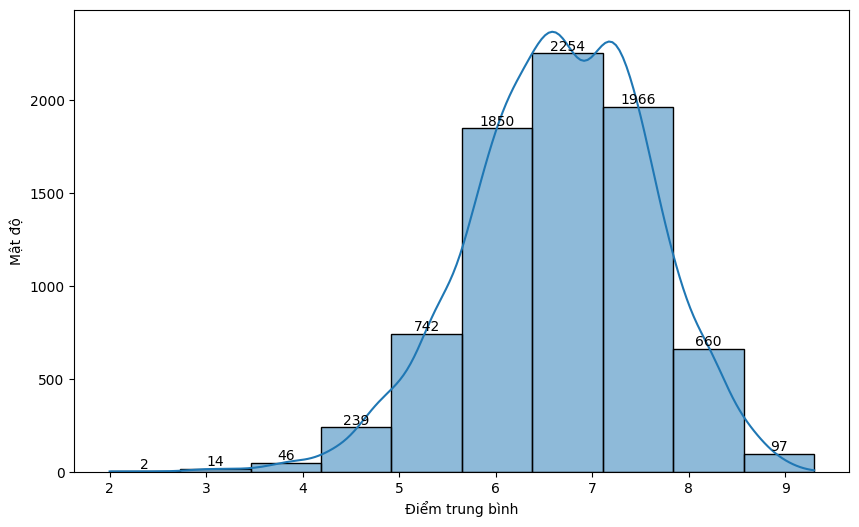

In [141]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_processed,
    x='score',
    kde=True,
    stat='count',
    legend=False,
    bins=10
)
for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height(), 
             f'{p.get_height()}' if p.get_height() != 0 else '0',
             ha='center', va='bottom', fontsize=10, color='black')


plt.xlabel('Điểm trung bình')
plt.ylabel('Mật độ')
plt.show()

In [143]:
# score -> score_label, 0 -> less than 6 is bad, 6-7 is average, 7-8 is good, above 8 is great

df_processed['score_label'] = pd.cut(df_processed['score'],
                          bins=[-np.inf, 6, 7, 8, np.inf], 
                            labels=['Bad', 'Average', 'Good', 'Great'])
df_processed.head(2)

,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen,score_label
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great


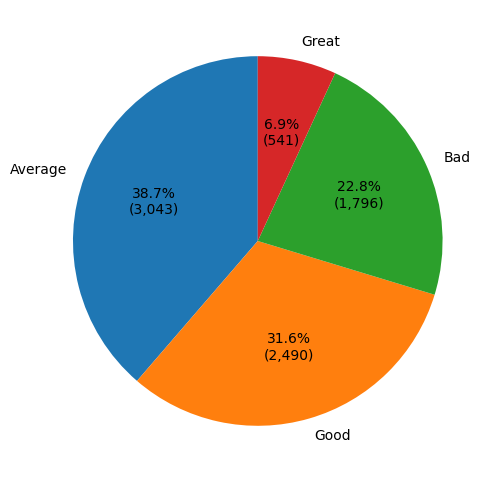

In [165]:
# Pie chart of score labels with counts 
plt.figure(figsize=(10, 6))
counts = df_processed['score_label'].value_counts()

def autopct_format(pct):
    total = sum(counts)
    count = int(round(pct * total / 100.0))
    return f'{pct:.1f}%\n({count:,})'

plt.pie(
    counts,
    labels=counts.index,
    autopct=autopct_format,
    startangle=90,
)

plt.show()



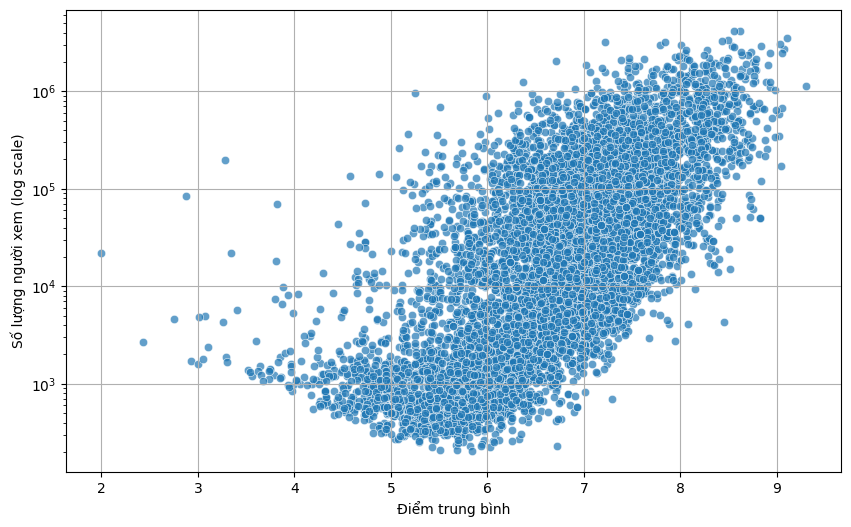

In [186]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
sns.scatterplot(
    data=df_processed,
    x='score',
    y='members',
    # hue='score_label',
    alpha=0.7
)
plt.ylabel('Số lượng người xem (log scale)')
plt.xlabel('Điểm trung bình')
plt.grid(True)
plt.show()

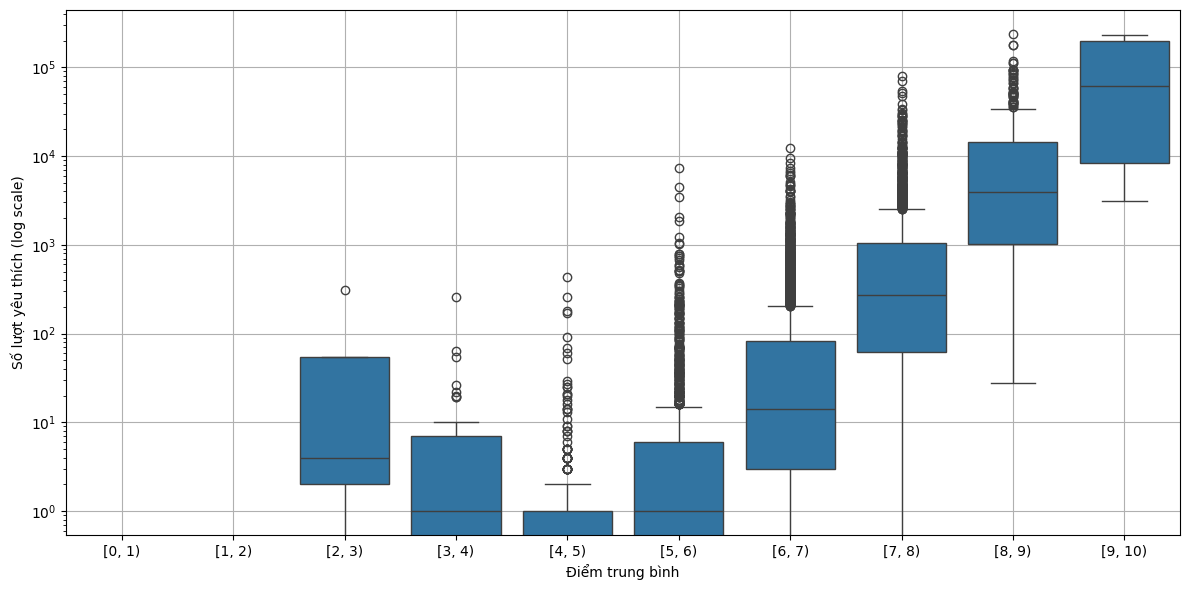

In [192]:
bin_edges = list(range(0, 11))
df_processed['score_bin'] = pd.cut(
    df_processed['score'],
    bins=bin_edges,
    include_lowest=True,
    right=False,  
)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_processed, x='score_bin', y='favorites')

plt.yscale('log')
plt.xlabel('Điểm trung bình')
plt.ylabel('Số lượt yêu thích (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()

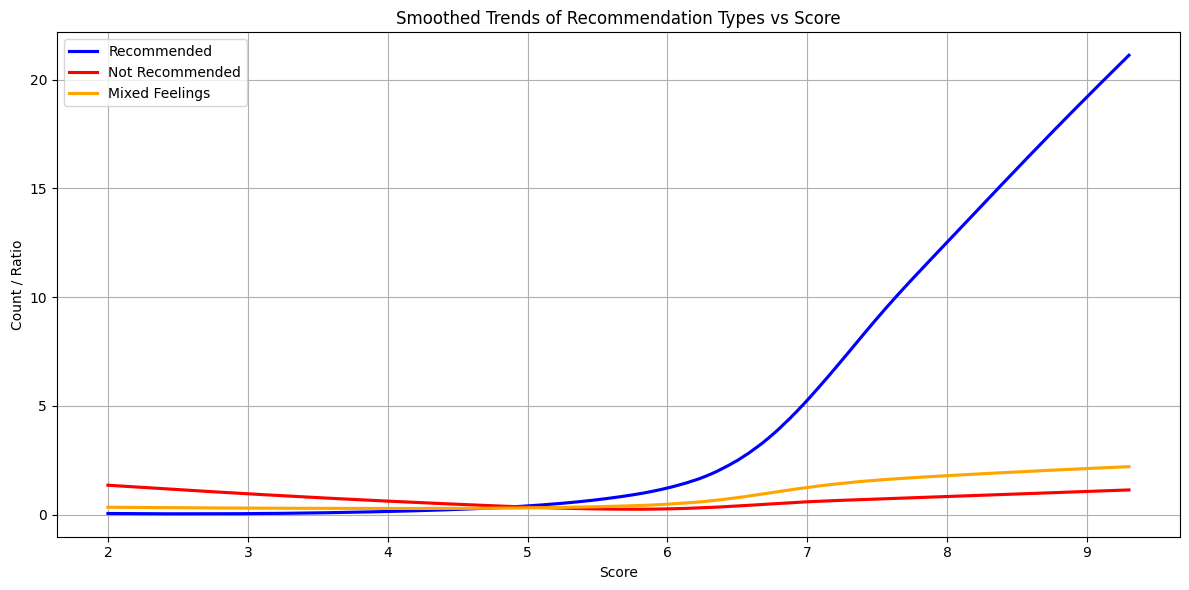

In [198]:
import statsmodels.api as sm  # needed if lowess is used

plt.figure(figsize=(12, 6))

sns.regplot(
    data=df_processed,
    x='score',
    y='Recommended',
    label='Recommended',
    lowess=True,
    scatter=False,
    color='blue'
)
sns.regplot(
    data=df_processed,
    x='score',
    y='NotRecommended',
    label='Not Recommended',
    lowess=True,
    scatter=False,
    color='red'
)
sns.regplot(
    data=df_processed,
    x='score',
    y='MixedFeelings',
    label='Mixed Feelings',
    lowess=True,
    scatter=False,
    color='orange'
)

plt.xlabel("Score")
plt.ylabel("Count / Ratio")
plt.title("Smoothed Trends of Recommendation Types vs Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


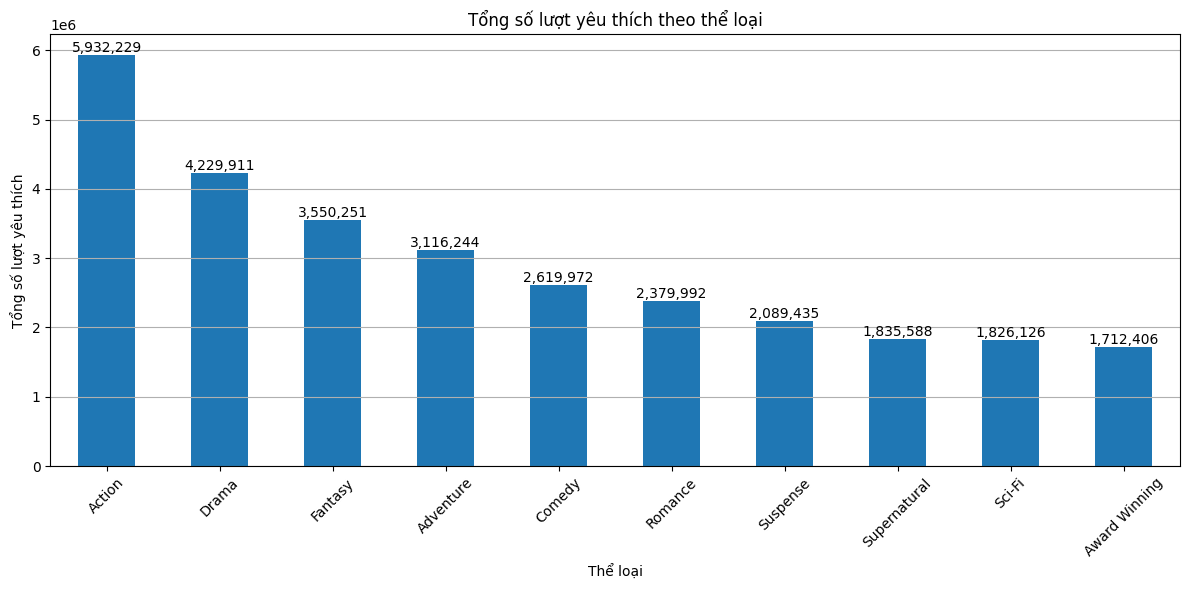

In [ ]:
# Total favorites by genre, remove the surfix genre_ from the column names, log scale y-axis
genre_cols = [col for col in df_processed.columns if col.startswith('genres_')]
total_favorites_by_genre = df_processed[genre_cols].multiply(df_processed['favorites'], axis=0).sum().sort_values(ascending=False)
total_favorites_by_genre.index = total_favorites_by_genre.index.str.replace('genres_', '', regex=False)

# get top 10
total_favorites_by_genre = total_favorites_by_genre.head(10)

plt.figure(figsize=(12, 6))
total_favorites_by_genre.plot(kind='bar')
# add number on top of each bar
for i, v in enumerate(total_favorites_by_genre):
    plt.text(i, v + 50, f'{v:,.0f}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Thể loại')
plt.ylabel('Tổng số lượt yêu thích')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [213]:
df_processed

,mal_id,title,title_english,title_japanese,type,episodes,status,score,rank,popularity,members,favorites,synopsis,genres,themes,demographics,studios,year,url,aired_date,review_tags_count,Creative,MixedFeelings,Recommended,Funny,NotRecommended,Informative,Well-written,genres_Action,genres_Adventure,genres_Avant Garde,genres_Award Winning,genres_Boys Love,genres_Comedy,genres_Drama,genres_Ecchi,genres_Erotica,genres_Fantasy,genres_Girls Love,genres_Gourmet,genres_Hentai,genres_Horror,genres_Mystery,genres_Romance,genres_Sci-Fi,genres_Slice of Life,genres_Sports,genres_Supernatural,genres_Suspense,themes_Adult Cast,themes_Anthropomorphic,themes_CGDCT,themes_Childcare,themes_Combat Sports,themes_Crossdressing,themes_Delinquents,themes_Detective,themes_Educational,themes_Gag Humor,themes_Gore,themes_Harem,themes_High Stakes Game,themes_Historical,themes_Idols (Female),themes_Idols (Male),themes_Isekai,themes_Iyashikei,themes_Love Polygon,themes_Love Status Quo,themes_Magical Sex Shift,themes_Mahou Shoujo,themes_Martial Arts,themes_Mecha,themes_Medical,themes_Military,themes_Music,themes_Mythology,themes_Organized Crime,themes_Otaku Culture,themes_Parody,themes_Performing Arts,themes_Pets,themes_Psychological,themes_Racing,themes_Reincarnation,themes_Reverse Harem,themes_Samurai,themes_School,themes_Showbiz,themes_Space,themes_Strategy Game,themes_Super Power,themes_Survival,themes_Team Sports,themes_Time Travel,themes_Urban Fantasy,themes_Vampire,themes_Video Game,themes_Villainess,themes_Visual Arts,themes_Workplace,demographics_Josei,demographics_Kids,demographics_Seinen,demographics_Shoujo,demographics_Shounen,score_label,score_bin,genre_combo
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,TV,26.0,Finished Airing,8.75,46.0,42,1975882,86621,"Crime is timeless. By the year 2071, humanity ...","[Action, Award Winning, Sci-Fi]","[Adult Cast, Space]",[],Sunrise,1998.0,https://myanimelist.net/anime/1/Cowboy_Bebop,1998-04-03T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,Movie,1.0,Finished Airing,8.38,215.0,642,398122,1711,"Another day, another bounty—such is the life o...","[Action, Sci-Fi]","[Adult Cast, Space]",[],Bones,2001.0,https://myanimelist.net/anime/5/Cowboy_Bebop__...,2001-09-01T00:00:00+00:00,"{'Recommended': 15, 'Mixed Feelings': 3, 'Not ...",0,3,15,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Great,"[8, 9)",
2,6,Trigun,Trigun,トライガン,TV,26.0,Finished Airing,8.22,378.0,260,803358,16863,"Vash the Stampede is the man with a $$60,000,0...","[Action, Adventure, Sci-Fi]",[Adult Cast],[Shounen],Madhouse,1998.0,https://myanimelist.net/anime/6/Trigun,1998-04-01T00:00:00+00:00,"{'Recommended': 16, 'Mixed Feelings': 2, 'Not ...",0,2,16,0,2,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Great,"[8, 9)",
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26.0,Finished Airing,7.23,3260.0,1950,123424,674,"Though hidden away from the general public, Wi...","[Action, Drama, Mystery, Supernatural]",[Detective],[],Sunrise,2002.0,https://myanimelist.net/anime/7/Witch_Hunter_R...,2002-07-03T00:00:00+00:00,"{'Recommended': 14, 'Not Recommended': 4, 'Mix...",0,2,14,0,4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Good,"[7, 8)",
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,TV,52.0,Finished Airing,6.92,4819.0,5655,16308,16,It is the dark century and the people are suff...,"[Action, Adventure, Fantasy]",[],[Sho